# Theory-Implied Correlation Algorithm
This blog post will cover the Theory-Implied Correlation (TIC) algorithm written by Marcos López de Prado __[available here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3484152)__.

## Introduction
Traditionally, correlation matrices have always played a large role in finance. They have been used in tasks from portfolio management to risk management and are calculated based on historical empirical observations. Although they are used so frequently, these correlation matrices often have poor predictive power and produce unreliable estimators. Additionally, there are also factor-based correlation matrices, which also do not perform well due to their non-hierarchical structure.

In a 2019 paper written by Marcos López de Prado, he introduced the TIC algorithm. This algorithm demonstrated a new machine learning approach to estimate correlation matrices based on economic theory, rather than historical observations or being factor-based. The TIC algorithm estimates a forward-looking correlation matrix implied by a proposed hierarchical structure of the assets and is computed in three main steps:
1. Fitting our tree graph structure based on the empirical correlation matrix
2. Deriving our correlation matrix from the linkage object
3. De-noising our correlation matrix

Today, we will be exploring this TIC algorithm as well as its implementation through the MlFinLab library. **Please keep in mind that this is a tutorial style post and we will be publishing a more theoretical article on the algorithm soon.**

## How the TIC algorithm works?
In this section, we will be going through a quick summary of each of the steps of the TIC algorithm, explaining them intuitively as well as implementing them in code in the next section. 

### Fitting our Tree Graph Structure

In this algorithm, the tree graph represents the economic theory and hierarchical structure of our assets. This tree structure is fit based upon our empirical correlation matrix. Essentially, this tree graph will tell us which assets are closely related each other and the relative distance between each other. This results in a binary tree using an agglommerative clustering technique which can be visualized through a dendrogram. Although we can visualize our results through a dendrogram, we must remember that this is not our tree graph. Our dendrogram always has two items per cluster while our actual tree graph could have one or more leaves per branch. Additionally, the dendrogam will always have $N - 1$ clusters while the tree graph may have an unlimited number of levels and our dendrogram incorporates the notion of distance but the tree graph does not.

The general steps for this part of the algorithm are as follows:
 1.  If there is no top level of the tree (tree root), this level is added so that all variables are included in one general cluster.

 2.  The empirical correlation matrix is transformed into a matrix of distances using the above formula:

    $$d_{i,j} = \sqrt{\frac{1}{2}(1 - \rho{i,j})}$$

 3.  For each level of the tree, the elements are grouped by elements from the higher level. The algorithm iterates from the lowest to the highest level of the tree.

 4.  A linkage object is created for these grouped elements based on their distance matrix. Each link in the linkage object is an array representing a cluster of two elements and has the following data as elements:
    - ID of the first element in a cluster

    - ID of the second element in a cluster

    - Distance between the elements

    - Number of atoms (simple elements from the portfolio and not clusters) inside

 5. A linkage object is transformed to reflect the previously created clusters.

 6.  A transformed local linkage object is added to the global linkage object

 7.  Distance matrix is adjusted to the newly created clusters - elements that are now in the new clusters are replaced by the clusters in the distance matrix. The distance from the new clusters to the rest of the elements in the distance matrix is calculated as a weighted average of distances of two elements in a cluster to the other elements. The weight is the number of atoms in an element. So, the formula is:

$$DistanceCluster = \frac{Distance_1 * NumAtoms_1 + Distance_2 * NumAtoms_2}{NumAtoms_1 + NumAtoms_2}$$

 8.  The linkage object, representing a dendrogram of all elements in a portfolio is the result of the first step of the algorithm. It sequentially clusters two elements together, while measuring how closely together the two elements are, until all elements are subsumed within the same cluster.

### Deriving our Correlation Matrix
We can now derive a correlation matrix from our linkage object returned by the first step. 

 1.  One by one, the clusters (each represented by a link in the linkage object) are decomposed to lists of atoms contained in each of the two elements of the cluster.

 2. The elements on the main diagonal of the resulting correlation matrix are set to 1s. The off-diagonal correlations between the variables are computed as:

$$\rho_{i,j} = 1 - 2 * d_{i,j}^{2}$$

### De-Noising our Correlation Matrix
In our last step, the correlation matrix is de-noised.

1.  The eigenvalues and eigenvectors of the correlation matrix are calculated.

2.  Marcenko-Pastur distribution is fit to the eigenvalues of the correlation matrix and the maximum theoretical eigenvalue is calculated.

3.  This maximum theoretical eigenvalue is set as a threshold and all the eigenvalues above the threshold are shrinked.

4.  The de-noised correlation matrix is calculated back from the eigenvectors and the new eigenvalues.

## Using the TIC algorithm with MlFinLab
In this section, we will go through a working example of using the TIC algorithm provided through the MlFinLab library

In [6]:
import mlfinlab as ml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Choosing the Dataset
The TIC algorithm combines both an economic theory and empirical data. Our economic theory is represented by a tree graph and our empirical data is represented by an empirical correlation matrix.

We will use the series of daily prices on a set of ETFs. Additionally, we need to determine the classification to use for the data. An example of a hierarchical structure for the financial instruments is the [MSCI’s Global Industry  Classification  Standard  (GICS)](https://www.msci.com/gics) that classifies investment  universes  in  terms  of four nested level. We will propose the classification of the ETFs similar to that of GICS.

In [7]:
# Getting the price data for ETFs
etf_prices = pd.read_csv('stock_prices.csv', parse_dates=True, index_col='Date')
etf_prices.head()

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,49.273335,35.389999,106.639999,52.919998,78.220001,87.629997,37.939999,47.759998,41.299999,79.500000,...,42.090000,51.173328,55.983330,74.529999,67.309998,144.929993,94.379997,77.360001,101.400002,130.630005
2008-01-03,49.716667,35.290001,107.000000,53.119999,78.349998,87.809998,37.919998,48.060001,42.049999,80.440002,...,42.029999,51.293331,55.599998,74.800003,67.500000,144.860001,94.250000,77.459999,101.519997,130.740005
2008-01-04,48.223331,34.599998,106.970001,51.759998,76.570000,88.040001,36.990002,46.919998,40.779999,77.500000,...,42.349998,49.849998,54.536671,72.980003,65.769997,141.309998,94.269997,77.550003,101.650002,128.169998
2008-01-07,48.576668,34.630001,106.949997,51.439999,76.650002,88.199997,37.259998,47.060001,40.220001,77.199997,...,43.230000,50.416672,56.116669,72.949997,65.650002,141.190002,94.680000,77.570000,101.720001,128.059998
2008-01-08,48.200001,34.389999,107.029999,51.320000,76.220001,88.389999,36.970001,46.400002,39.599998,75.849998,...,43.240002,49.566669,55.326672,72.400002,65.360001,138.910004,94.570000,77.650002,101.739998,125.849998


Note that we need to calculate the series of returns from a series of prices to calculate the correlation matrix

In [8]:
# Class with returns calculation function
ret_est = ml.portfolio_optimization.ReturnsEstimators()

# Calculating returns
etf_returns = ret_est.calculate_returns(etf_prices)
etf_returns.head()

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-03,0.008997,-0.002826,0.003376,0.003779,0.001662,0.002054,-0.000527,0.006281,0.018160,0.011824,...,-0.001426,0.002345,-0.006847,0.003623,0.002823,-0.000483,-0.001377,0.001293,0.001183,0.000842
2008-01-04,-0.030037,-0.019552,-0.000280,-0.025602,-0.022719,0.002619,-0.024525,-0.023720,-0.030202,-0.036549,...,0.007614,-0.028139,-0.019125,-0.024332,-0.025630,-0.024506,0.000212,0.001162,0.001281,-0.019657
2008-01-07,0.007327,0.000867,-0.000187,-0.006182,0.001045,0.001817,0.007299,0.002984,-0.013732,-0.003871,...,0.020779,0.011368,0.028971,-0.000411,-0.001824,-0.000849,0.004349,0.000258,0.000689,-0.000858
2008-01-08,-0.007754,-0.006930,0.000748,-0.002333,-0.005610,0.002154,-0.007783,-0.014025,-0.015415,-0.017487,...,0.000231,-0.016860,-0.014078,-0.007539,-0.004417,-0.016148,-0.001162,0.001031,0.000197,-0.017258
2008-01-09,0.032780,0.003199,-0.000747,0.021824,0.007216,-0.001584,0.002975,0.000431,0.006313,0.013184,...,0.010870,0.019435,0.062779,0.001381,0.021267,0.010510,0.001903,-0.001159,-0.000885,0.008820


In [9]:
# Now the empirical correlation matrix can be calculated
etf_corr = etf_returns.corr()

# Getting the tree graph for ETFs
etf_tree = pd.read_csv('classification_tree.csv')

# Having a look at the tree structure of ETFs
etf_tree

,TICKER,SECTOR,REGION,TYPE
0,EEM,101010,1010,10
1,EWG,102010,1020,10
2,TIP,203010,2030,20
3,EWJ,104010,1040,10
4,EFA,103010,1030,10
5,IEF,203010,2030,20
6,EWQ,102010,1020,10
7,EWU,102010,1020,10
8,XLB,103020,1030,10
9,XLE,103030,1030,10


The proposed tree structure for ETFs has four levels:
1. Ticker of the ETF
2. Sector of the ETF
 - XXXX10 - General/No sector
 - XXXX20 - Materials
 - XXXX30 - Energy
 - XXXX40 - Financial
 - XXXX50 - Technology
 - XXXX60 - Utilities
3. Region of the ETF
 - XX10 - Emerging markets
 - XX20 - Europe
 - XX30 - US and Canada
 - XX40 - Asia
4. Type of the ETF
 - 10 - Equity ETF
 - 20 - Bond ETF
 
From here, we can now use the algorithm to calculate the theory-implied correlation matrix.

In [11]:
# Calculating the relation of sample length T to the number of variables N
# It's used for de-noising the TIC matrix
tn_relation = etf_returns.shape[0] / etf_returns.shape[1]

# Class with TIC function
tic = ml.portfolio_optimization.TIC()

# Calculating theory-implied correlation matrix
etf_tic = tic.tic_correlation(etf_tree, etf_corr, tn_relation, kde_bwidth=0.01)

# Setting the indexes of the theory-implied correlation matrix
etf_tic = pd.DataFrame(etf_tic, index=etf_corr.index, columns=etf_corr.index)

We can visualize the difference between the Empirical correlation matrix and the Theory-implied correlation matrix using heatmaps.

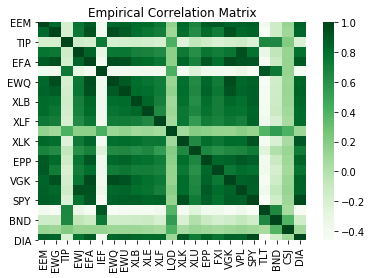

In [18]:
# Plotting the heatmap of the Empirical correlation matrix
sns.heatmap(etf_corr, cmap="Greens")
plt.title('Empirical Correlation Matrix')
plt.show()

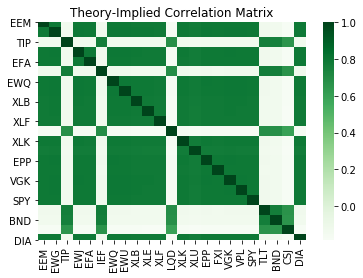

In [19]:
# Plotting the heatmap of the Theory-implied correlation matrix
sns.heatmap(etf_tic, cmap="Greens")
plt.title('Theory-Implied Correlation Matrix')
plt.show()

We can see that the TIC matrix is less noisy and has a clearly defined structure in comparison to the empirical correlation matrix.

We can also measure the similarity of the two matrices using the correlation matrix distance introduced by _Herdin_ and _Bonek_ in a paper __AMIMO Correlation Matrix based Metric for Characterizing Non-Stationarity__ [available here](https://publik.tuwien.ac.at/files/pub-et_8791.pdf).

In [20]:
# Calculating the correlation matrix distance
distance = tic.corr_dist(etf_corr, etf_tic)

# Printing the result
print('The distance between empirical and the theory-implied correlation matrices is' , distance)

The distance between empirical and the theory-implied correlation matrices is 0.035661302090136404


The correlation matrices are different but are not too far apart. This shows that the theory-implied correlation matrix blended theory-implied views with empirical ones.

## Conclusion
Throughout this post, we learned the intuition behind Marcos López de Prado's Theory-Implied Correlation algorithm for estimating correlation matrices. We also saw how we can utilize MlFinLab's implementation to apply this technique out-of-the-box.

The following links provide a more detailed exploration of the algorithm for further reading. Additionally, we will be posting a more theoretical blog post on this article soon.

### Research Notebooks
- [Jupyter Notebook](https://github.com/hudson-and-thames/research/blob/master/Portfolio%20Optimisation%20Tutorials/Theory%20Implied%20Correlation%20(TIC)/TIC.ipynb)

### Official MlFinLab Documentation:
- [Theory-Implied Correlation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/theory_implied_correlation.html)

### Algorithms:
- [Theory-Implied Correlation - Marcos López de Prado](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3484152)
- [Correlation Matrix Distance - Herdin and Bonek](https://publik.tuwien.ac.at/files/pub-et_8791.pdf)